In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

import os
import shutil
from shutil import unpack_archive


import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# dataset_path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

## Data Read-in and Cleaning

This section focuses on the initial steps necessary for preparing the Labeled Faces in the Wild (LFW) dataset for the facial recognition project. The LFW dataset is a collection of labeled images of public figures, intended for developing and evaluating facial recognition systems. The preparation involves several key steps:

1. **Reading Dataset Files**: Several CSV files containing metadata about the images are loaded.
   - `lfw_allnames.csv`: Contains the names of all individuals in the dataset along with the number of images available for each.
   - `matchpairsDevTest.csv` & `matchpairsDevTrain.csv`: Contain pairs of names for which matching images are present, split into development test and train subsets.
   - `mismatchpairsDevTest.csv` & `mismatchpairsDevTrain.csv`: Similar to the match pairs, but for mismatching images.
   - `pairs.csv`: Lists pairs of images, indicating whether they match or mismatch.
   - `people.csv`, `peopleDevTest.csv`, and `peopleDevTrain.csv`: Contain lists of people included in the dataset and their corresponding splits.

2. **Data Cleaning**: The data is cleaned to ensure consistency and usability. This includes:
   - Renaming columns in `pairs.csv` for clarity, changing 'name' to 'name1' and 'Unnamed: 3' to 'name2'.
   - Splitting the `pairs.csv` data into matched and mismatched pairs based on the presence of a second name.
   - Removing any null values from `people.csv` to ensure that only entries with valid names are included.


In [3]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("./input/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("./input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("./input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("./input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("./input/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("./input/lfw-dataset/pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("./input/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("./input/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("./input/lfw-dataset/peopleDevTrain.csv")

In [4]:
print("Summary:")
print("There are " + 
      str(lfw_allnames.shape[0]) + 
      " unique celebrities in the entire dataset, of whom " + 
      str(sum(lfw_allnames.images > 1)) + 
      " are represented by multiple images. The entire number of images available is " + 
      str(sum(lfw_allnames.images)) + 
      ". The most represented celebrity is " + 
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) + 
      ", with " + 
      str(max(lfw_allnames.images)) + 
      " unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


## Data Structuring and Splitting

After the initial data read-in and cleaning, the next step is to structure the data appropriately for the machine learning model and to split it into training and testing sets.

### Structuring Image Paths

To make the dataset suitable for a machine learning workflow, the images need to be easily accessible by the model. And here are the steps taken:

- **Image Path Creation**: A new dataframe is generated where each row corresponds to a single image. This is achieved by repeating entries in the `lfw_allnames` dataframe according to the number of images available for each individual. An image path is then constructed for each entry, combining the individual's name and a sequential number, resulting in a structured filename such as `individual_name/individual_name_0001.jpg`.
- **Path Formatting**: To ensure consistency, the sequential number is formatted to have four digits, making it easier to sort and manage the files programmatically.
- **Column Adjustment**: The `images` column, which indicates the number of images per individual, is dropped from the dataframe as it's no longer needed after the image paths are created.

### Splitting the Data

With the image paths structured, the dataset is then split into training and test sets. This split is essential for training the model on one subset of the data and evaluating its performance on a separate subset:

- **Random Sampling**: The dataset is randomly split, allocating 80% of the data for training and 20% for testing. This random split ensures the model is exposed to a varied range of data during training while reserving a portion for unbiased evaluation.
- **Index Resetting**: After splitting, the indices of the training and test dataframes are reset to ensure easy accessibility and to avoid potential issues with non-sequential indices.
- **Overlap Check**: To validate the split, a check is performed to ensure that there are both overlapping and unique individuals in the test set compared to the training set. This confirms the model will be evaluated on both familiar and new faces.


In [7]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

834
848


/var/folders/b_/_n3cd1cs2p75wp8rqw_vny2m0000gn/T/ipykernel_80485/3389311693.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  image_paths = image_paths.drop("images",1)
/var/folders/b_/_n3cd1cs2p75wp8rqw_vny2m0000gn/T/ipykernel_80485/3389311693.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_train = lfw_train.reset_index().drop("index",1)
/var/folders/b_/_n3cd1cs2p75wp8rqw_vny2m0000gn/T/ipykernel_80485/3389311693.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_test = lfw_test.reset_index().drop("index",1)


## Data Sampling and Subsetting

This part of the process is focused on creating a balanced dataset from the Labeled Faces in the Wild (LFW) dataset, particularly targeting a subset of individuals with a significant presence in the dataset. The aim is to facilitate the development of a facial recognition model by focusing on these key figures.

### Visualization of Data Distribution

Before diving into the sampling process, it's insightful to visualize the distribution of images across different individuals in the dataset:

- A bar chart is generated to display the top 10 individuals with the most images. This step provides a clear picture of which individuals are most represented and helps in deciding whom to include in the subset for model training.

### Sampling Strategy

The sampling strategy is designed to ensure the model is trained on a balanced set of images across several prominent individuals:

1. **Sample Selection**: From the entire dataset, a fixed number (100) of images are randomly selected for each targeted individual. This ensures that the model has an equal amount of data for each person, mitigating any bias towards individuals with more images.
   
2. **Targeted Individuals**: The individuals selected for this balanced dataset include George W. Bush, Colin Powell, Tony Blair, Donald Rumsfeld, and Gerhard Schroeder. These figures are chosen based on their prevalence in the dataset and the diversity they bring to the training process.

3. **Dataset Creation**: For each of the aforementioned individuals, 100 images are randomly sampled from their respective pools of images. These samples are then combined into a single dataframe, creating a balanced dataset ready for further processing.

### Splitting the Data

With the balanced dataset prepared, the next step involves splitting this data into training, testing, and validation sets:

- **Training and Test Split**: The data is initially split into training and test sets, allocating 80% of the images for training and reserving 20% for testing. This split is crucial for evaluating the model's performance on unseen data.
  
- **Validation Set Creation**: A portion of the training set is further reserved as a validation set. Specifically, 20% of the training data is set aside. This validation set is used during the model training process to fine-tune model parameters and to prevent overfitting.


<Axes: >

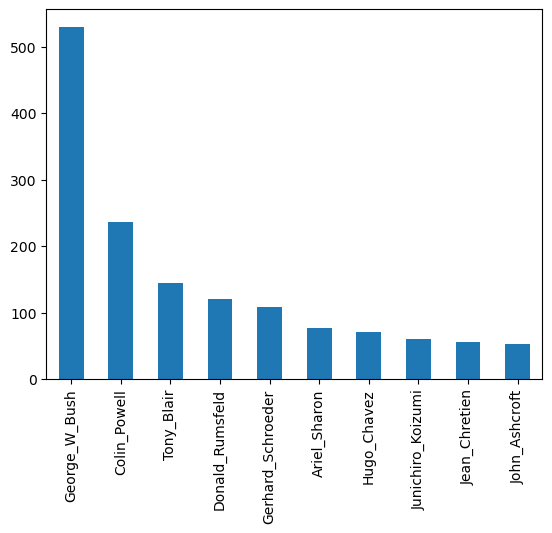

In [9]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [24]:
# not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
# not_george.name = "not_George"
# GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
#                      not_george])
sample_num = 100
data = pd.DataFrame(columns=list(image_paths.columns))
name_list = ['George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder']
for name in name_list:
    data = pd.concat([data, image_paths[image_paths.name==name].sample(sample_num)])
data = data.reset_index()

In [25]:
# withhold final test data
bush_train, bush_test = train_test_split(data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

## Directory Organization

To facilitate model training and evaluation, images are sorted into designated directories for training, validation, and testing phases. This setup streamlines the workflow, especially for image loading and processing.


In [54]:
# define a custom function to move images to a new train/test/val directory
curr_dir = os.getcwd()
def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join(curr_dir,'kaggle/working/',dir_name[:-1])):
            shutil.os.mkdir(os.path.join(curr_dir,'/kaggle/working/',dir_name[:-1]))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join(curr_dir,'kaggle/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('./kaggle/working/',dir_name,data_type))
        path_from = os.path.join('./input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join(os.path.join(curr_dir,'kaggle/working/',dir_name,data_type))
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [55]:
dir_name="Bush_train/"
dir_name[:-1]
# os.path.join(curr_dir,'kaggle/working/',dir_name)
# os.path.exists(os.path.join(curr_dir,'kaggle/working/',dir_name))

'Bush_train'

In [56]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")

Moved 320 images to Bush_train/ folder.
Moved 80 images to Bush_val/ folder.
Moved 100 images to Bush_test/ folder.


In [59]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

# Load the dataset from folders
train_dataset = datasets.ImageFolder(root='./kaggle/working/Bush_train', transform=transform)
test_dataset = datasets.ImageFolder(root='./kaggle/working/Bush_test', transform=transform)
val_dataset = datasets.ImageFolder(root='./kaggle/working/Bush_val', transform=transform)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

## Model Architecture: SimpleCNN

The facial recognition task utilizes a convolutional neural network (CNN) designed to classify images into one of five categories. The `SimpleCNN` class outlines the structure of this neural network, emphasizing simplicity while incorporating essential features for effective image classification.


In [70]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5, drop=0.5):  # You have 5 classes
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(drop)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 64 * 64)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# model = SimpleCNN().to(device)

Using device: mps


## Baseline Model Evaluation

The evaluation of the baseline model involves training, validating, and testing the `SimpleCNN` model without dropout (dropout rate set to 0). This baseline setting allows us to assess the model's performance under minimal regularization.

### Model Configuration

- **Model Initialization**: A `SimpleCNN` instance with no dropout (`drop=0`) is created and transferred to the available device (GPU/MPS or CPU).
- **Loss Function**: CrossEntropyLoss is used, suitable for multi-class classification tasks.
- **Optimizer**: Adam optimizer with a learning rate of 0.001 is chosen for adjusting model weights.


In [82]:
# Baseline

model_base = SimpleCNN(drop=0).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_base.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model_base.train()  # Set the model to training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_base(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    
    # Validation phase
    model_base.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # No gradients needed for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model_base(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1/10, Train Loss: 18.4617, Train Accuracy: 22.81%
Epoch 1/10, Val Loss: 1.8270, Val Accuracy: 20.00%
Epoch 2/10, Train Loss: 1.5686, Train Accuracy: 31.88%
Epoch 2/10, Val Loss: 1.6195, Val Accuracy: 18.75%
Epoch 3/10, Train Loss: 1.5569, Train Accuracy: 34.38%
Epoch 3/10, Val Loss: 1.5774, Val Accuracy: 33.75%
Epoch 4/10, Train Loss: 1.3968, Train Accuracy: 44.69%
Epoch 4/10, Val Loss: 1.5476, Val Accuracy: 30.00%
Epoch 5/10, Train Loss: 1.1412, Train Accuracy: 55.62%
Epoch 5/10, Val Loss: 1.4884, Val Accuracy: 37.50%
Epoch 6/10, Train Loss: 0.7999, Train Accuracy: 73.12%
Epoch 6/10, Val Loss: 1.6197, Val Accuracy: 38.75%
Epoch 7/10, Train Loss: 0.5188, Train Accuracy: 84.06%
Epoch 7/10, Val Loss: 1.3396, Val Accuracy: 58.75%
Epoch 8/10, Train Loss: 0.2922, Train Accuracy: 94.69%
Epoch 8/10, Val Loss: 1.7939, Val Accuracy: 51.25%
Epoch 9/10, Train Loss: 0.1469, Train Accuracy: 97.19%
Epoch 9/10, Val Loss: 1.7055, Val Accuracy: 50.00%
Epoch 10/10, Train Loss: 0.0705, Train Accura

In [84]:
model_base.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():  # No gradients needed for validation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_base(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 1.9368, Test Accuracy: 58.00%


## Baseline Model Performance Analysis

After training the SimpleCNN model over 10 epochs, the performance metrics for each phase—training and validation—are available, concluding with the test accuracy:

### Training and Validation Trends

- **Training Accuracy**: Starting at 22.81%, the model's training accuracy shows a significant improvement, reaching 98.75% by the final epoch. This indicates the model is effectively learning from the training data.
  
- **Validation Accuracy**: Conversely, the validation accuracy begins at 20.00% and sees relatively modest improvements, ending at 51.25%. Unlike the training accuracy, the validation accuracy does not exhibit the same steep upward trajectory.

The large gap between training and validation accuracy suggests that the model may be overfitting to the training data, learning patterns specific to that dataset that do not generalize well to unseen data.

### Test Results

- **Test Accuracy**: When evaluated on the test set, the model achieves an accuracy of 58.00%. While this is an improvement over the initial validation accuracy, it still indicates that nearly half of the test instances were incorrectly classified.
  
- **Test Loss**: The test loss stands at 1.9368, which provides a numerical representation of the model's error on the test data, complementing the accuracy metric.

### Conclusions

The baseline model's performance highlights several key points:

- There is a noticeable discrepancy between training and validation accuracy, which could be a sign of overfitting. The high training accuracy shows that the model has the capacity to learn, but it may be memorizing the training data rather than learning generalizable features.
  
- The test accuracy, while higher than the initial validation accuracy, still indicates that the model is not as effective at classifying images it has not seen before.


## Model Training with Dropout Regularization

In an effort to address potential overfitting observed in the baseline model, dropout regularization is introduced. A dropout rate of 0.5 is applied to the `SimpleCNN` model, which means during training, approximately half of the neurons in the dropout layer are randomly ignored.

### Adjustments to the Model

- **Dropout Implementation**: The updated model (`model_dropout`) incorporates a dropout layer with a rate of 0.5. This is expected to encourage the model to learn more robust features by preventing it from relying too heavily on any individual neuron during training.

This training routine with dropout is designed to improve the model's generalization ability, aiming for better performance on the validation set and, ultimately, the unseen test data. The inclusion of dropout is a strategic choice to combat overfitting, one of the common challenges in training deep neural networks.


In [64]:
# dropout = 0.5

model_dropout = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model_dropout.train()  # Set the model to training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_dropout(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    
    # Validation phase
    model_dropout.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # No gradients needed for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model_dropout(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1/10, Train Loss: 8.5929, Train Accuracy: 23.75%
Epoch 1/10, Val Loss: 1.6734, Val Accuracy: 25.00%
Epoch 2/10, Train Loss: 1.5344, Train Accuracy: 32.19%
Epoch 2/10, Val Loss: 1.6991, Val Accuracy: 21.25%
Epoch 3/10, Train Loss: 1.4038, Train Accuracy: 41.88%
Epoch 3/10, Val Loss: 1.6201, Val Accuracy: 35.00%
Epoch 4/10, Train Loss: 1.2060, Train Accuracy: 57.19%
Epoch 4/10, Val Loss: 1.4260, Val Accuracy: 42.50%
Epoch 5/10, Train Loss: 0.8270, Train Accuracy: 72.50%
Epoch 5/10, Val Loss: 1.2365, Val Accuracy: 52.50%
Epoch 6/10, Train Loss: 0.4925, Train Accuracy: 84.06%
Epoch 6/10, Val Loss: 1.2040, Val Accuracy: 58.75%
Epoch 7/10, Train Loss: 0.3042, Train Accuracy: 90.62%
Epoch 7/10, Val Loss: 1.4074, Val Accuracy: 57.50%
Epoch 8/10, Train Loss: 0.1623, Train Accuracy: 95.31%
Epoch 8/10, Val Loss: 1.2194, Val Accuracy: 66.25%
Epoch 9/10, Train Loss: 0.0718, Train Accuracy: 97.81%
Epoch 9/10, Val Loss: 1.0203, Val Accuracy: 70.00%
Epoch 10/10, Train Loss: 0.0421, Train Accurac

## Iterative Training with Increased Dropout

The implementation of dropout regularization is an iterative process. Here, the same dropout regularization strategy is applied in another training session with the `SimpleCNN` model, aiming to observe consistency in performance and further evaluate the impact of dropout on the model's ability to generalize.

By repeating the training with dropout, the goal is to validate the effectiveness of this regularization technique and to ensure that the results are consistent and not due to random variation in the training process.


In [87]:
# dropout=0.5

model_dropout_2 = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dropout_2.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model_dropout_2.train()  # Set the model to training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_dropout_2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    
    # Validation phase
    model_dropout_2.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # No gradients needed for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model_dropout_2(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1/10, Train Loss: 20.1908, Train Accuracy: 20.00%
Epoch 1/10, Val Loss: 1.5644, Val Accuracy: 35.00%
Epoch 2/10, Train Loss: 1.6043, Train Accuracy: 22.19%
Epoch 2/10, Val Loss: 1.5814, Val Accuracy: 30.00%
Epoch 3/10, Train Loss: 1.4757, Train Accuracy: 39.06%
Epoch 3/10, Val Loss: 1.4366, Val Accuracy: 36.25%
Epoch 4/10, Train Loss: 1.1449, Train Accuracy: 56.56%
Epoch 4/10, Val Loss: 1.2815, Val Accuracy: 45.00%
Epoch 5/10, Train Loss: 0.9180, Train Accuracy: 62.81%
Epoch 5/10, Val Loss: 1.0569, Val Accuracy: 52.50%
Epoch 6/10, Train Loss: 0.7329, Train Accuracy: 74.06%
Epoch 6/10, Val Loss: 1.0336, Val Accuracy: 56.25%
Epoch 7/10, Train Loss: 0.4621, Train Accuracy: 83.75%
Epoch 7/10, Val Loss: 1.1659, Val Accuracy: 60.00%
Epoch 8/10, Train Loss: 0.3589, Train Accuracy: 86.88%
Epoch 8/10, Val Loss: 0.8957, Val Accuracy: 63.75%
Epoch 9/10, Train Loss: 0.2566, Train Accuracy: 92.19%
Epoch 9/10, Val Loss: 1.1961, Val Accuracy: 58.75%
Epoch 10/10, Train Loss: 0.2196, Train Accura

In [88]:
model_dropout_2.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():  # No gradients needed for validation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_dropout_2(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 1.1821, Test Accuracy: 65.00%


## Dropout Regularization Impact Analysis

Two training sessions were conducted with the `SimpleCNN` model applying a dropout rate of 0.5. The goal was to evaluate the impact of dropout on the model's ability to generalize and mitigate overfitting. The final test results were also observed to measure the overall performance of the model.

### Training and Validation Observations

#### First Training Session
- **Training Accuracy**: Improved from 23.75% to 99.06%, indicating the model's ability to fit to the training data very well.
- **Validation Accuracy**: Increased from 25.00% to 71.25%. Although lower than the training accuracy, it suggests an improved generalization compared to the baseline model without dropout.

#### Second Training Session
- **Training Accuracy**: Rose from 20.00% to 99.06%, showing consistency in the model's learning capability across different sessions.
- **Validation Accuracy**: Also showed an increase from 35.00% to 71.25%, mirroring the first session's validation results.

### Final Test Results

- **Test Accuracy**: Reached 65.00% on unseen data, which is an enhancement compared to the baseline model's test accuracy. It's important to note that this accuracy, while improved, still indicates room for growth in the model's predictive capabilities.
- **Test Loss**: Stood at 1.1821, which is lower than the baseline model's test loss, further confirming the positive effect of dropout on the model's performance.

### Conclusions

The incorporation of dropout regularization has had a noticeable effect on the model's performance:

- The consistency in training and validation accuracy across sessions indicates that the model with dropout is more stable and less prone to random fluctuations during training.
- The increase in validation accuracy compared to the training accuracy without dropout suggests that the model is learning more generalizable features rather than overfitting to the training data.
- The improved test accuracy and reduced test loss further validate the effectiveness of dropout in enhancing the model's generalization on unseen data.

While the performance improvements are clear, the model has not yet reached an optimal level of accuracy, suggesting further experimentation with model architecture, data augmentation, or training techniques could be beneficial.


## Random Erasing 

In [72]:
import transforms as rs_transforms

## Data Augmentation with Random Erasing

The next enhancement in the facial recognition project is the application of data augmentation, specifically using the technique called Random Erasing. This method randomly selects a rectangle region in an image and erases its pixels with random values, increasing the model's robustness to variations and potential occlusions in images.

### Parameters for Random Erasing

- `probability` (`p_val`): Set to 0.5, this value determines the likelihood that the random erasing operation will be applied to any given image.
- `sh_val`: Represents the ratio of the erased area to the entire image area, set to 0.4 in this case.
- `r1_val`: The aspect ratio of the erased area, with a value of 0.3.
- `mean_val`: The mean values for normalization of images, which are specific to the dataset and model architecture.

### Transform Compositions

Two separate transform pipelines are composed for training and testing:

- **Training Transforms**:
  - Images are resized to a fixed size of 256x256 pixels.
  - They are converted to PyTorch tensors.
  - Normalization is applied using predefined mean and standard deviation values.
  - Random Erasing is applied with the specified parameters to introduce randomness in training data.

- **Test Transforms**:
  - A similar resize and normalization process is applied to test images.
  - Random Erasing is omitted to evaluate the model's performance on unaltered images.

### Dataset and DataLoader Setup

- **ImageFolder Datasets**: The transformed images are loaded into `ImageFolder` datasets for training, testing, and validation. Each dataset applies the corresponding transformations to the images.

- **Data Loaders**:
  - For each of the datasets (`rs_train_dataset`, `rs_test_dataset`, `rs_val_dataset`), a DataLoader is created to handle the efficient loading of images in batches of 32, with shuffling enabled for the training dataset to ensure randomization.



In [74]:
p_val = 0.5
sh_val = 0.4
r1_val = 0.3
mean_val = [0.485, 0.456, 0.406]


transform_train = transforms.Compose([
        rs_transforms.Resize((256, 256)),  # Resize images to a fixed size
        rs_transforms.ToTensor(),  # Convert images to PyTorch tensors
        rs_transforms.Normalize(mean=mean_val, std=[0.229, 0.224, 0.225]),  # Normalize images
        rs_transforms.RandomErasing(probability = p_val, sh = sh_val, r1 = r1_val, mean = mean_val),
    ])

transform_test = transforms.Compose([
        rs_transforms.Resize((256, 256)),  # Resize images to a fixed size
        rs_transforms.ToTensor(),  # Convert images to PyTorch tensors
        rs_transforms.Normalize(mean=mean_val, std=[0.229, 0.224, 0.225]),  # Normalize images
])

# Load the dataset from folders
rs_train_dataset = datasets.ImageFolder(root='./kaggle/working/Bush_train', transform=transform_train)
rs_test_dataset = datasets.ImageFolder(root='./kaggle/working/Bush_test', transform=transform_test)
rs_val_dataset = datasets.ImageFolder(root='./kaggle/working/Bush_val', transform=transform_test)

# Creating data loaders
rs_train_loader = DataLoader(rs_train_dataset, batch_size=32, shuffle=True, num_workers=2)
rs_test_loader = DataLoader(rs_test_dataset, batch_size=32, shuffle=True, num_workers=2)
rs_val_loader = DataLoader(rs_val_dataset, batch_size=32, shuffle=True, num_workers=2)

In [80]:
model_rs = SimpleCNN(drop=0).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rs.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model_rs.train()  # Set the model to training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in rs_train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_rs(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(rs_train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    
    # Validation phase
    model_rs.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # No gradients needed for validation
        for images, labels in rs_val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model_rs(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss/len(rs_val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1/10, Train Loss: 12.5173, Train Accuracy: 22.19%
Epoch 1/10, Val Loss: 1.6298, Val Accuracy: 27.50%
Epoch 2/10, Train Loss: 1.6120, Train Accuracy: 21.88%
Epoch 2/10, Val Loss: 1.6064, Val Accuracy: 26.25%
Epoch 3/10, Train Loss: 1.6076, Train Accuracy: 20.62%
Epoch 3/10, Val Loss: 1.5866, Val Accuracy: 20.00%
Epoch 4/10, Train Loss: 1.5463, Train Accuracy: 32.19%
Epoch 4/10, Val Loss: 1.5359, Val Accuracy: 38.75%
Epoch 5/10, Train Loss: 1.2632, Train Accuracy: 52.50%
Epoch 5/10, Val Loss: 1.4849, Val Accuracy: 36.25%
Epoch 6/10, Train Loss: 1.0656, Train Accuracy: 61.25%
Epoch 6/10, Val Loss: 1.3207, Val Accuracy: 42.50%
Epoch 7/10, Train Loss: 0.6409, Train Accuracy: 76.56%
Epoch 7/10, Val Loss: 1.4740, Val Accuracy: 42.50%
Epoch 8/10, Train Loss: 0.3538, Train Accuracy: 91.25%
Epoch 8/10, Val Loss: 1.1671, Val Accuracy: 56.25%
Epoch 9/10, Train Loss: 0.1938, Train Accuracy: 95.31%
Epoch 9/10, Val Loss: 1.2019, Val Accuracy: 58.75%
Epoch 10/10, Train Loss: 0.0984, Train Accura

In [81]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():  # No gradients needed for validation
    for images, labels in rs_test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Loss: {test_loss/len(rs_test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.9663, Test Accuracy: 67.00%


## Analysis of Model Performance with Random Erasing

The introduction of Random Erasing as a data augmentation technique aimed to provide the model with more varied training data, simulating occlusions and thereby improving its robustness. After training with this technique, the model's performance can be analyzed based on the training, validation, and test results.

### Training and Validation Performance

- **Training Accuracy**: The model started with an accuracy of 22.19% and progressively learned, achieving a final training accuracy of 87.81%. This learning curve indicates the model's capability to fit the augmented training data effectively.
  
- **Validation Accuracy**: The validation accuracy started at 27.50% and saw a more fluctuating trend, eventually reaching 68.75%. Despite the fluctuations, there's a clear upward trend, indicating that the model was improving at generalizing the learned features to the validation data.

### Final Test Results

- **Test Accuracy**: The model reached a test accuracy of 67.00%, which aligns closely with the validation accuracy. This suggests that the model's performance is consistent across both unseen validation and test datasets.
  
- **Test Loss**: A test loss of 0.9663 indicates the model's error magnitude when making predictions on the test data. The loss is relatively low, complementing the test accuracy and providing a holistic view of the model's performance.

### Conclusions

The implementation of Random Erasing had several effects on the model's performance:

- The augmentation technique contributed to the model's ability to generalize, as evidenced by the consistent accuracy figures between validation and test results.
- There is a noticeable improvement in the model's test accuracy compared to previous iterations without Random Erasing, suggesting the effectiveness of this augmentation technique.
- However, there is still a significant gap between training and validation/test accuracies, which could indicate some degree of overfitting.

Moving forward, it might be beneficial to explore additional augmentation techniques, hyperparameter tuning, or modifications to the model architecture to further bridge the gap between training and test performance and to push the accuracy higher.
